In [1]:
import pickle
from helper_fxns import convert_param_vec_dict_to_param_dict, gelman_rubin_trace_dict, print_convergence_summary, sample_plots, create_trace_matrix, plot_histograms
from earm.lopez_embedded import model
%matplotlib inline
import os
import numpy as np
from corner import corner
import matplotlib.pyplot as plt
import seaborn as sns

/Users/Erin/Library/Python/2.7/lib/python/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/Erin/Library/Python/2.7/lib/python/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
#os.chdir('/data/lola/shockle/data_for_paper_attempt2/no_pymc')
os.chdir('/Users/Erin/git/accre_data_analysis')

In [3]:
traces = {}
for trace in ['a', 'b', 'c', 'd']:
    traces[trace] = [np.load('earm_dreamzs_12chain_'+str(trace)+'_sampled_params_chain_0.npy')]
    traces[trace][0] = np.concatenate((traces[trace][0], np.load('earm_dreamzs_12chain_'+str(trace)+'_2_sampled_params_chain_0.npy')), axis=0)
    for chain in range(1, 12):
        traces[trace].append(np.load('earm_dreamzs_12chain_'+str(trace)+'_sampled_params_chain_'+str(chain)+'.npy'))
        traces[trace][chain] = np.concatenate((traces[trace][chain], np.load('earm_dreamzs_12chain_'+str(trace)+'_2_sampled_params_chain_'+str(chain)+'.npy')), axis=0)
    

In [20]:
traces['a'][0][0]

array([ -5.18643308,  -3.95023414,  -2.69947518,   0.13624668,
       -10.17927274,  -0.16496423,   1.40701633,  -5.19454034,
         7.9653147 , -11.91927164,   6.46613854,  -9.09334031,
        13.88432681,  -4.6451658 ,   1.17811588,   5.86701439,
        11.81824448,  -5.55924851,  13.71644181,  -1.19466363,
         2.05156388, -11.45119048,  -1.21724318,   1.23891972,
       -14.67917364,   2.82992749,  -5.38618568,   9.80433123,
       -11.50536617,  14.51596769,  -1.09176928, -13.31321158,
       -14.6615416 ,  -3.71812456,  -3.5633048 ,   1.41984237,
        -4.38894574,  -7.96592646,   7.68352179,  -1.14205663,
        -5.91842565,  -0.81425334,  -4.95097525,  -8.70041975,
        -9.19511864,  -7.24711712,  -3.89254597,  -6.25508945,
        -4.11266285,  -0.1731117 , -11.83915961,  10.7679664 ,
        -2.302795  ,   1.367805  , -12.96039721,   2.72149169,
        -6.28750887,   0.4461057 ,  -2.16977059,   6.03004128,
       -11.58522934,   1.43897535,  -4.63613956, -10.01

In [4]:
logps = {}
for trace in ['a', 'b', 'c', 'd']:
    logps[trace] = [np.load('earm_dreamzs_12chain_'+str(trace)+'_logps_chain_0.npy')]
    logps[trace][0] = np.concatenate((logps[trace][0], np.load('earm_dreamzs_12chain_'+str(trace)+'_2_logps_chain_0.npy')), axis=0)
    print 'Logp of trace: ',trace,' chain: 0 = ',logps[trace][-1]
    for chain in range(1, 12):
        logps[trace].append(np.load('earm_dreamzs_12chain_'+str(trace)+'_logps_chain_'+str(chain)+'.npy'))
        logps[trace][chain] = np.concatenate((logps[trace][chain], np.load('earm_dreamzs_12chain_'+str(trace)+'_2_logps_chain_'+str(chain)+'.npy')), axis=0)
        print 'Logp of trace: ',trace,' chain: ',chain,' = ',logps[trace][-1][-1]

Logp of trace:  a  chain: 0 =  [[-1039028.47270373]
 [-1038954.7989302 ]
 [-1036600.66231548]
 ..., 
 [   -4976.66249989]
 [   -4976.3245805 ]
 [   -4976.3245805 ]]
Logp of trace:  a  chain:  1  =  [-4976.38118657]
Logp of trace:  a  chain:  2  =  [-4980.15044619]
Logp of trace:  a  chain:  3  =  [-4974.1533938]
Logp of trace:  a  chain:  4  =  [-4980.13287244]
Logp of trace:  a  chain:  5  =  [-4981.79732379]
Logp of trace:  a  chain:  6  =  [-4975.26022055]
Logp of trace:  a  chain:  7  =  [-4981.04469638]
Logp of trace:  a  chain:  8  =  [-4976.36831679]
Logp of trace:  a  chain:  9  =  [-4971.56460573]
Logp of trace:  a  chain:  10  =  [-4980.99504885]
Logp of trace:  a  chain:  11  =  [-4958.27753136]
Logp of trace:  b  chain: 0 =  [[-1028273.06339091]
 [-1028273.06339091]
 [-1028273.06339091]
 ..., 
 [   -4868.28589796]
 [   -4868.28589796]
 [   -4868.28589796]]
Logp of trace:  b  chain:  1  =  [-4884.55215283]
Logp of trace:  b  chain:  2  =  [-4933.14470219]
Logp of trace:  b  

In [5]:
from earm_exp_parameters import earm_rates
uni_idx = []
norm_idx = []
uni_n = 0
norm_n = 0
for i, param in enumerate(model.parameters_rules()):
    if earm_rates[param.name]['type'] == 'uniform':
        uni_idx.append(i)
        uni_n += 1
    elif earm_rates[param.name]['type'] == 'normal':
        norm_idx.append(i)
        norm_n += 1

kf mito:  -14.8452186131  -  0.154781386928
kr mito:  -4.15478138693  -  13.8452186131
kf cyto:  -16.0001205731  -  -1.00012057306
kr cyto:  -2.99987942694  -  15.0001205731


In [6]:
traces['b'][0][:,72]

array([-9.55013099, -9.55013099, -9.55013099, ..., -8.35405317,
       -8.35405317, -8.35405317])

In [7]:
traces['a'][0][:,72]

array([-7.40025238, -7.40025238, -7.46903134, ..., -9.09548405,
       -9.09548405, -9.09548405])

array([-8.04675968, -8.04675968, -8.04675968, ..., -7.94000787,
       -7.94000787, -7.94000787])

In [6]:
param_trace_dicts = {}
param_trace_dict_a = {}
gelman_rubin_dicts = {}
param_trace_dict_a['param_list'] = [param.name for param in model.parameters_rules()]
for run in ['a', 'b', 'c', 'd']:
    uni_param_n = 0
    norm_param_n = uni_n
    for i, param in enumerate(model.parameters_rules()):
        if i in uni_idx:
            param_trace_dict_a[param.name] = [traces[run][chain][:,uni_param_n] for chain in range(len(traces[run]))]
            uni_param_n += 1
        else:
            param_trace_dict_a[param.name] = [traces[run][chain][:,norm_param_n] for chain in range(len(traces[run]))]
            norm_param_n += 1
    param_trace_dicts[run] = param_trace_dict_a
    gelman_rubin_dicts[run] = gelman_rubin_trace_dict(param_trace_dict_a)
    param_trace_dict_a = {}
    param_trace_dict_a['param_list'] = [param.name for param in model.parameters_rules()]

In [9]:
print_convergence_summary(param_trace_dicts['a'])

Number of parameters with GR below 1.2:  99  of  105  parameters.
Percent of parameters with GR below 1.2:  94.2857142857
Number of parameters with GR below 1.1:  94  of  105  parameters.
Percent of parameters with GR below 1.1:  89.5238095238


[99, 94.28571428571428, 94, 89.52380952380953]

In [10]:
print_convergence_summary(param_trace_dicts['b'])

Number of parameters with GR below 1.2:  95  of  105  parameters.
Percent of parameters with GR below 1.2:  90.4761904762
Number of parameters with GR below 1.1:  86  of  105  parameters.
Percent of parameters with GR below 1.1:  81.9047619048


[95, 90.47619047619048, 86, 81.9047619047619]

In [11]:
print_convergence_summary(param_trace_dicts['c'])

Number of parameters with GR below 1.2:  95  of  105  parameters.
Percent of parameters with GR below 1.2:  90.4761904762
Number of parameters with GR below 1.1:  91  of  105  parameters.
Percent of parameters with GR below 1.1:  86.6666666667


[95, 90.47619047619048, 91, 86.66666666666667]

In [12]:
print_convergence_summary(param_trace_dicts['d'])

Number of parameters with GR below 1.2:  96  of  105  parameters.
Percent of parameters with GR below 1.2:  91.4285714286
Number of parameters with GR below 1.1:  92  of  105  parameters.
Percent of parameters with GR below 1.1:  87.619047619


[96, 91.42857142857143, 92, 87.61904761904762]

In [13]:
param_trace_dicts['d']['bind_L_R_to_LR_kf']

[array([-7.14293921, -7.14293921, -7.14293921, ..., -7.34136038,
        -7.34136038, -7.34136038]),
 array([-8.48109991, -8.39810051, -8.39810051, ..., -7.28525642,
        -7.28525642, -7.28525642]),
 array([-8.39958492, -8.39958492, -8.64155146, ..., -8.37873491,
        -8.37873491, -8.37873491]),
 array([-8.48109991, -8.48109991, -8.48109991, ..., -7.59811715,
        -7.59811715, -7.59811715]),
 array([-8.48109991, -8.48109991, -8.05062061, ..., -7.95727101,
        -7.95727101, -7.95727101]),
 array([-8.48109991, -8.48109991, -8.32058417, ..., -7.64023852,
        -7.64023852, -7.64023852]),
 array([-8.30880603, -8.30880603, -8.23671361, ..., -7.4556069 ,
        -7.4556069 , -7.4556069 ]),
 array([-8.48109991, -8.48109991, -8.48109991, ..., -9.42135914,
        -9.42135914, -9.42135914]),
 array([-8.0727679 , -8.0727679 , -8.0727679 , ..., -8.72740646,
        -8.72740646, -8.72740646]),
 array([-8.19066303, -8.19066303, -8.01112442, ..., -6.4554257 ,
        -6.4554257 , -6.45

120000
12
120000


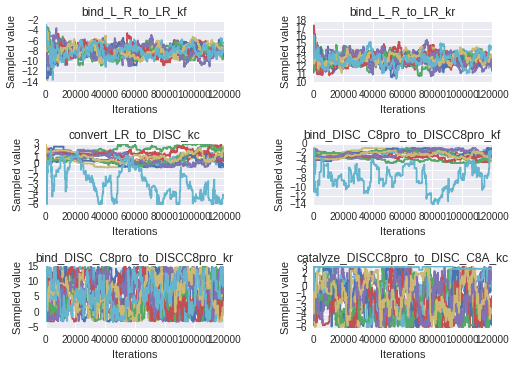

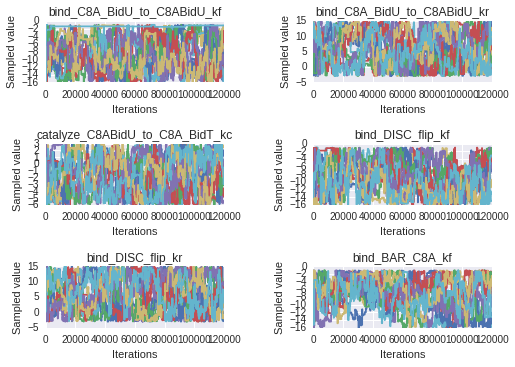

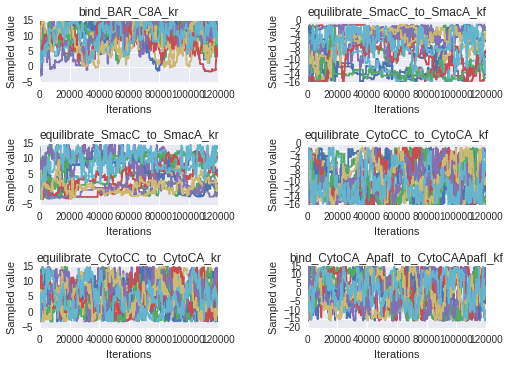

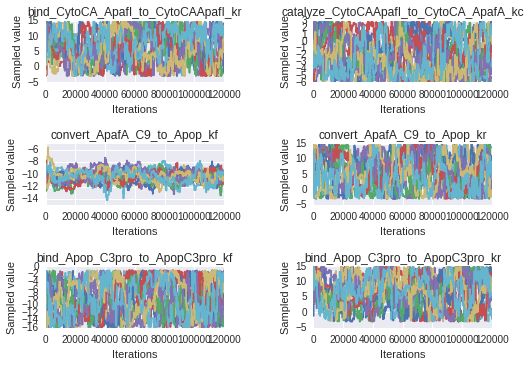

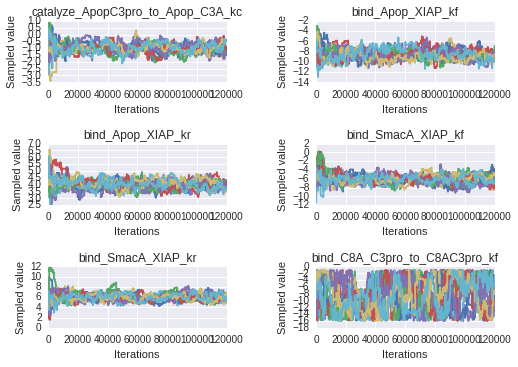

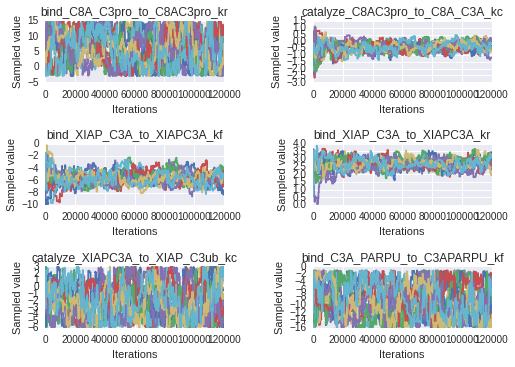

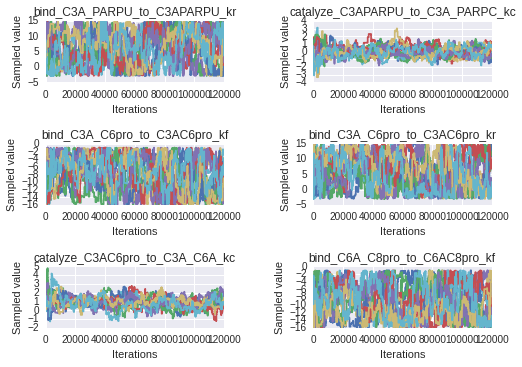

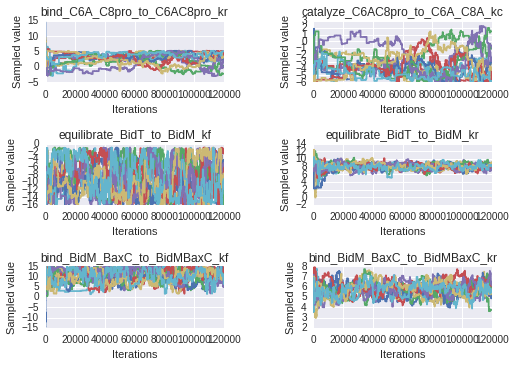

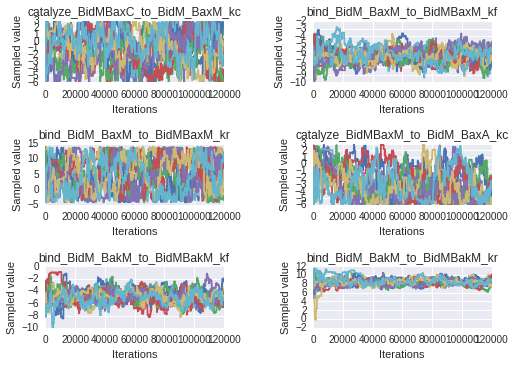

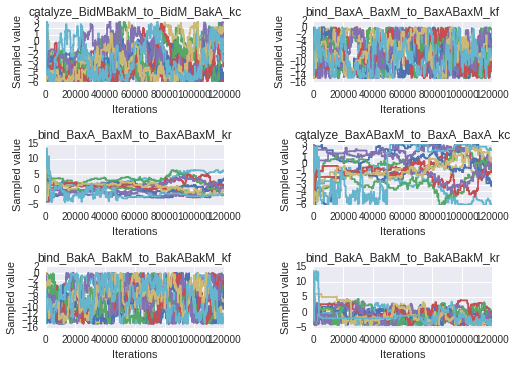

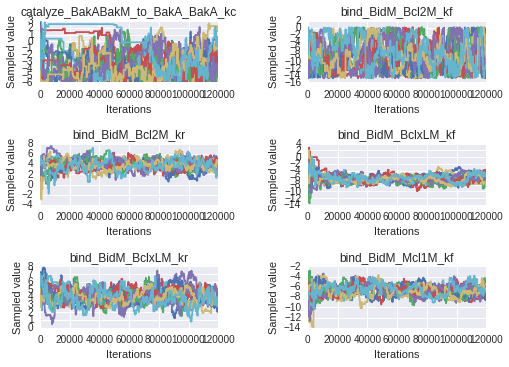

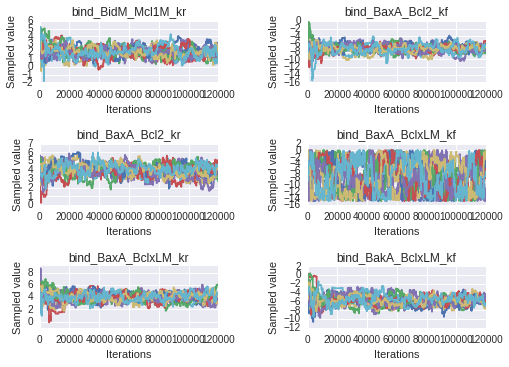

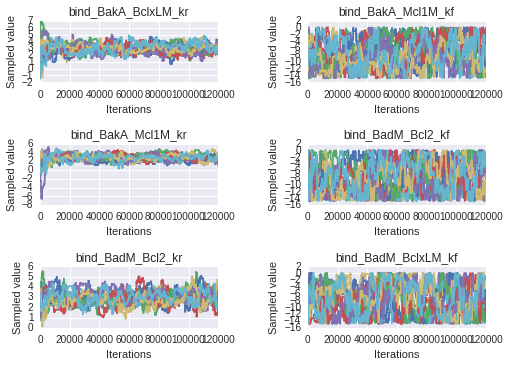

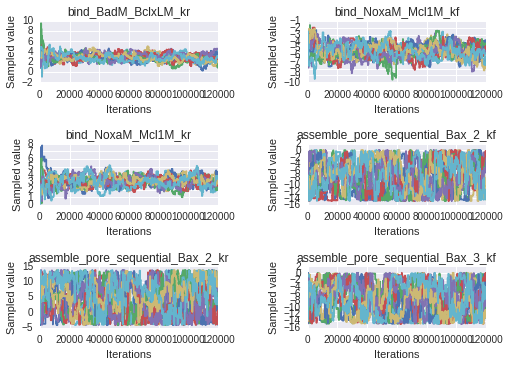

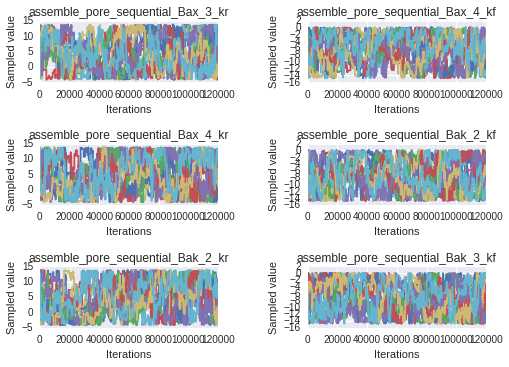

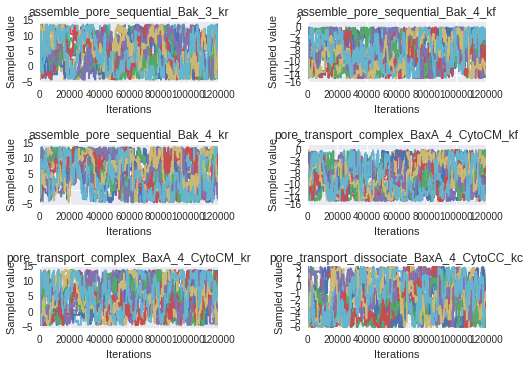

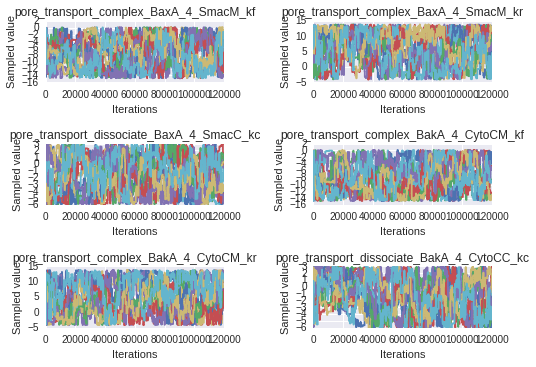

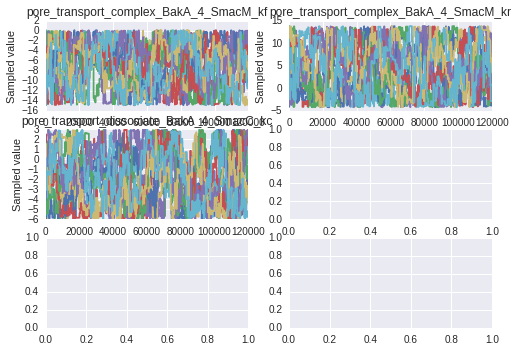

In [14]:
sample_plots(param_trace_dicts['a'])

In [7]:
trace_arr_a = create_trace_matrix(param_trace_dicts['a'], burnin=30000, thin=10)
trace_arr_b = create_trace_matrix(param_trace_dicts['b'], burnin=30000, thin=10)
trace_arr_c = create_trace_matrix(param_trace_dicts['c'], burnin=30000, thin=10)
trace_arr_d = create_trace_matrix(param_trace_dicts['d'], burnin=30000, thin=10)

In [16]:
trace_arrays = [trace_arr_a, trace_arr_b, trace_arr_c, trace_arr_d]

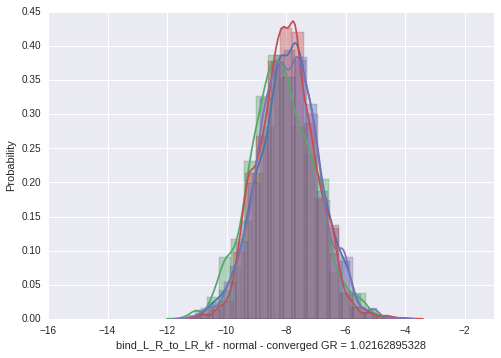

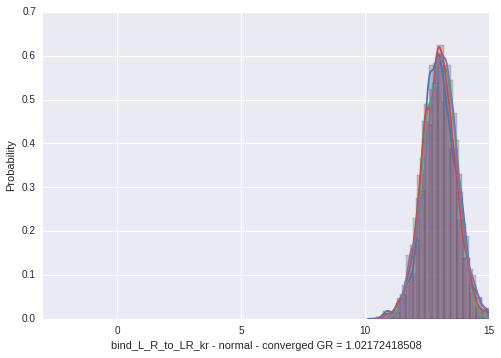

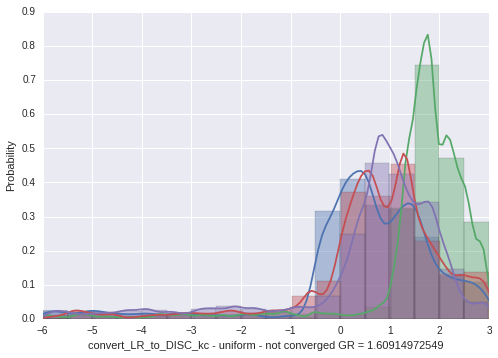

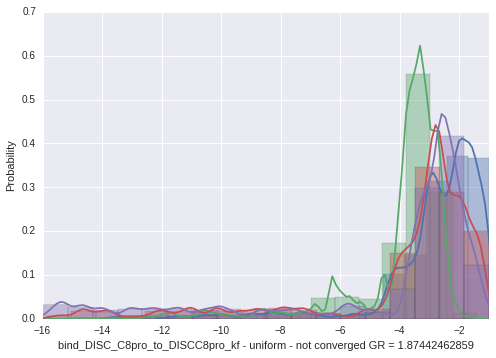

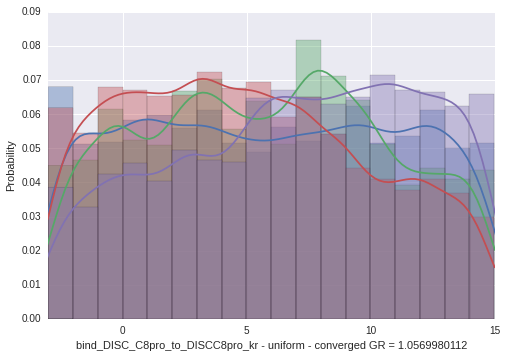

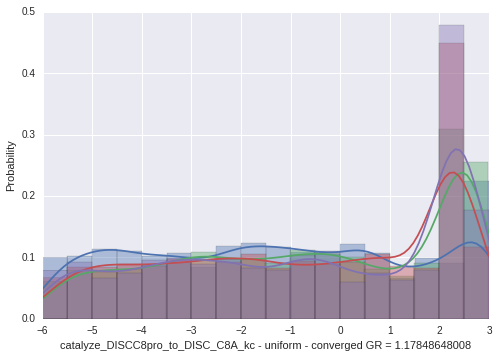

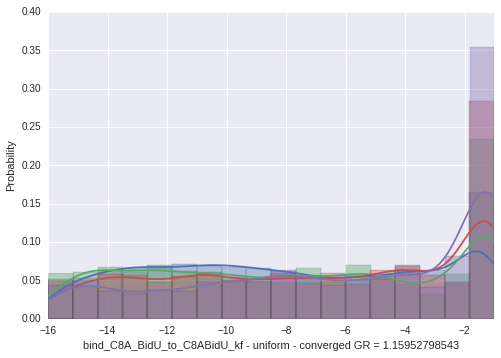

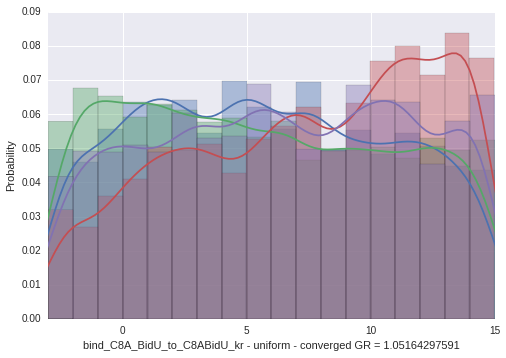

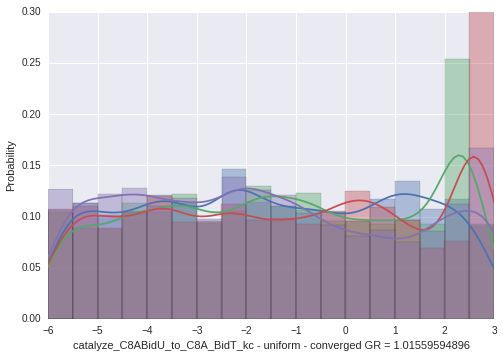

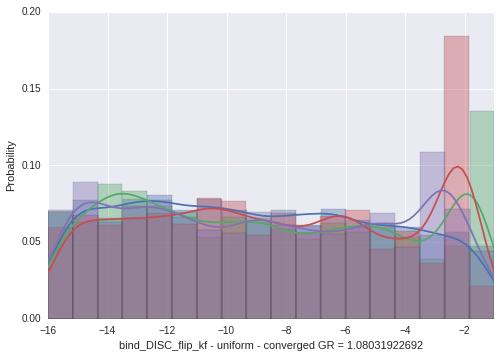

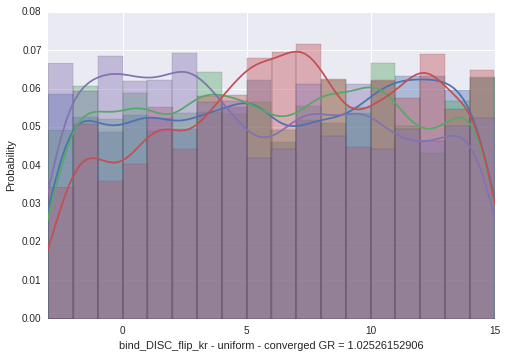

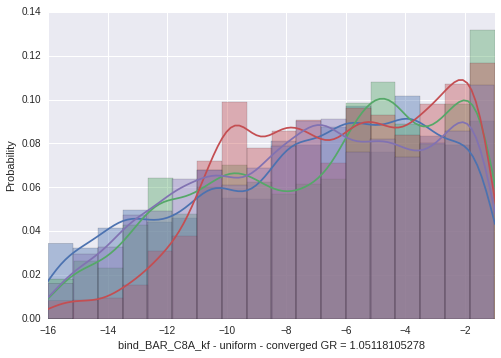

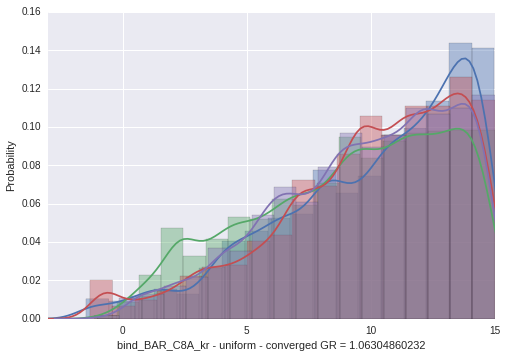

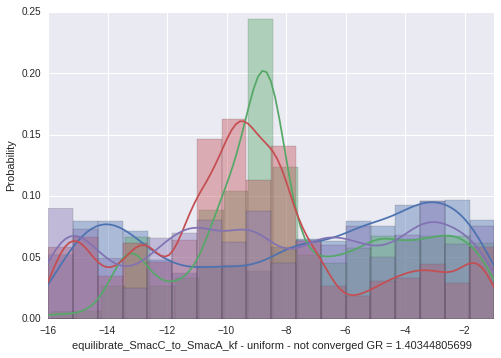

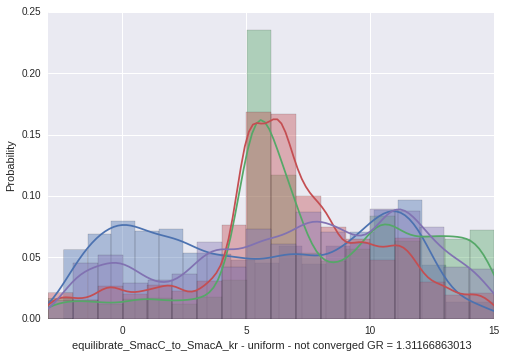

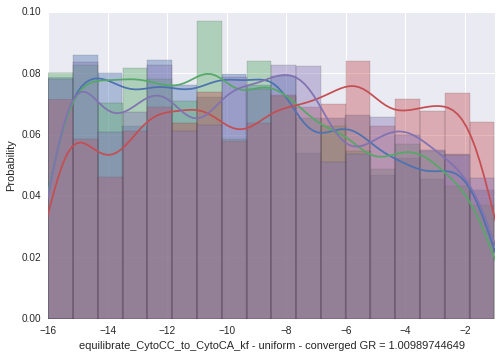

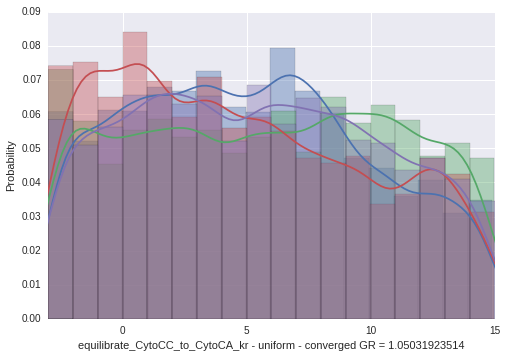

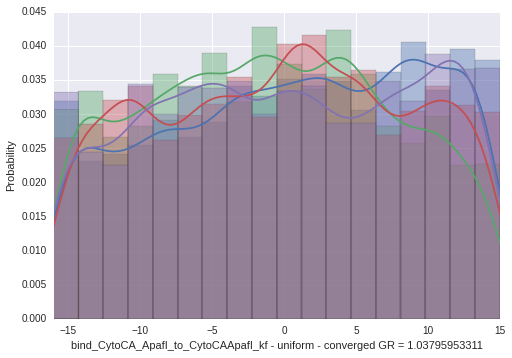

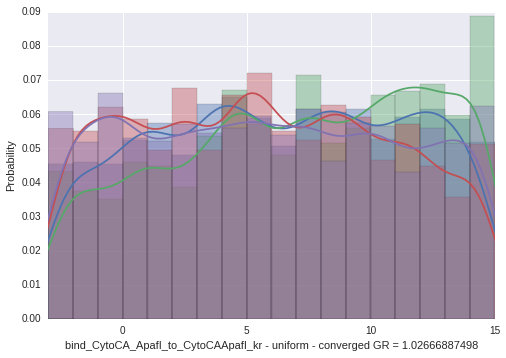

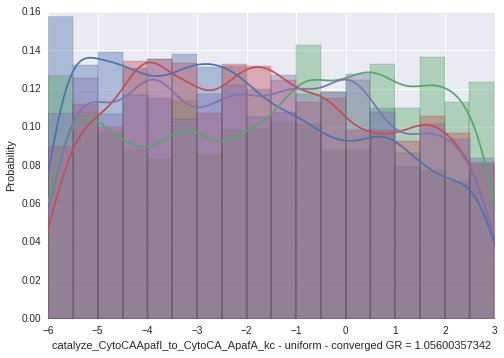

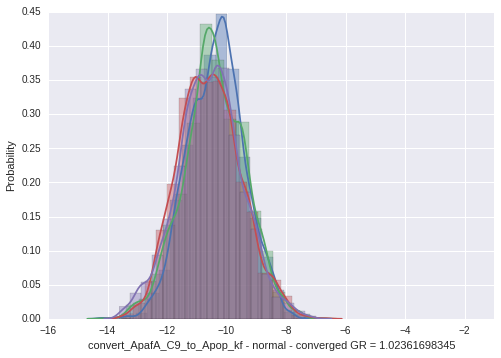

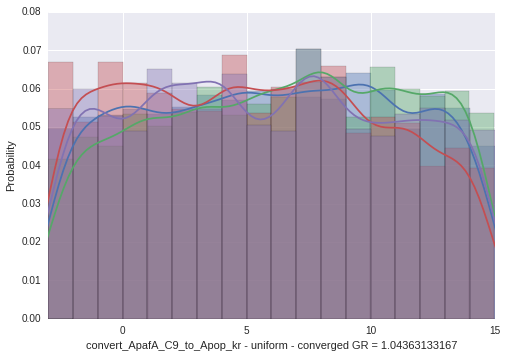

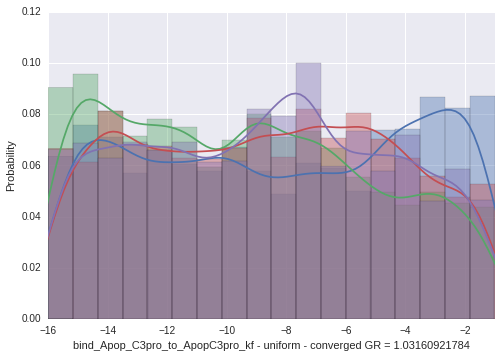

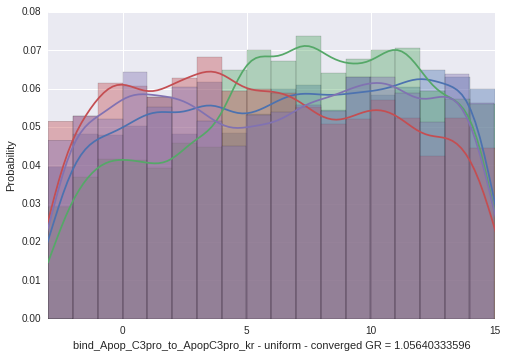

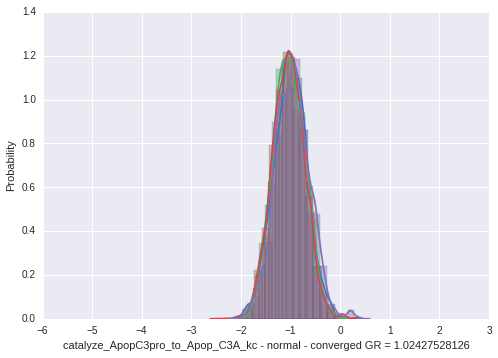

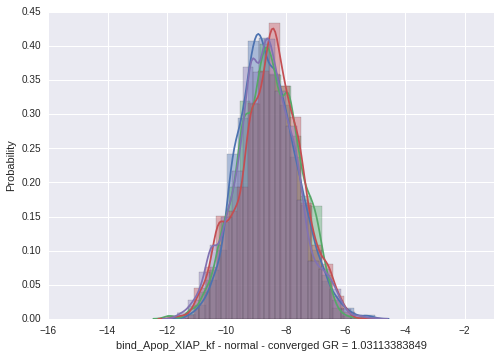

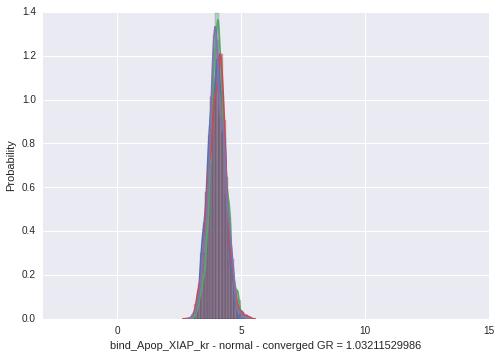

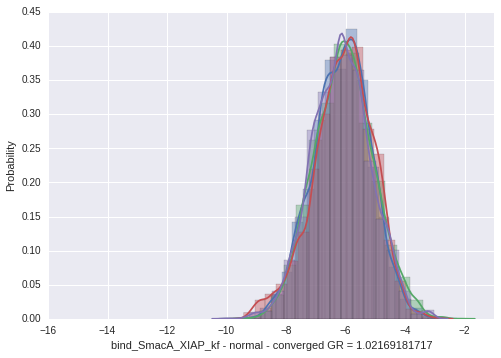

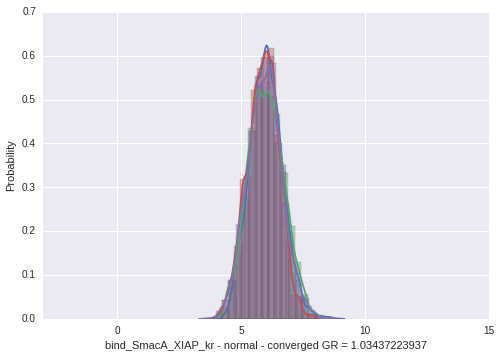

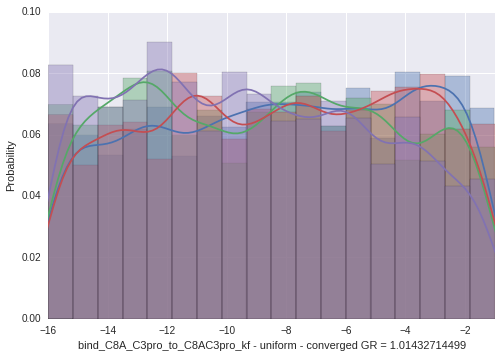

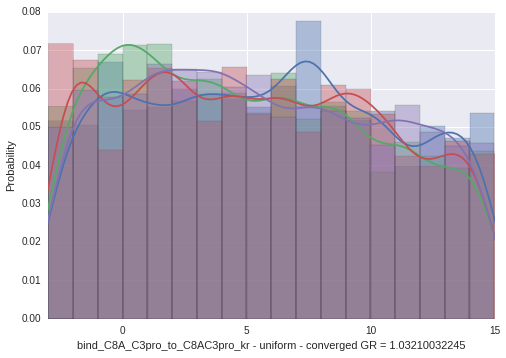

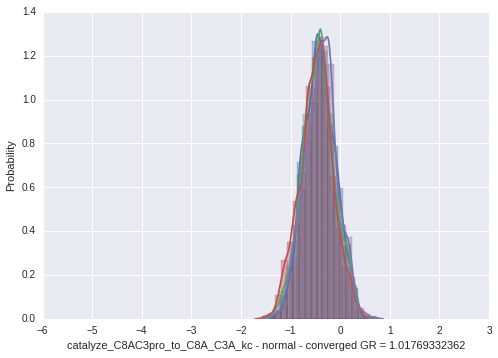

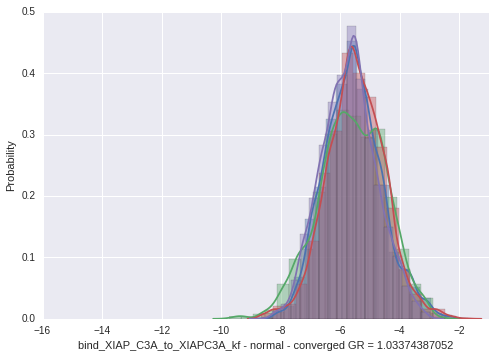

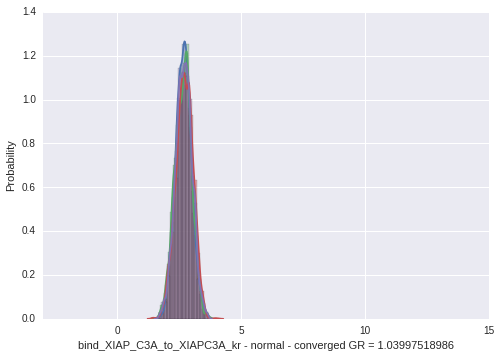

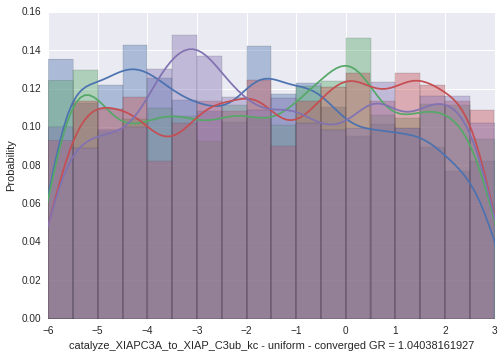

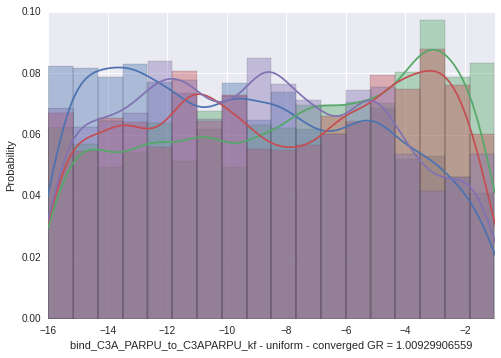

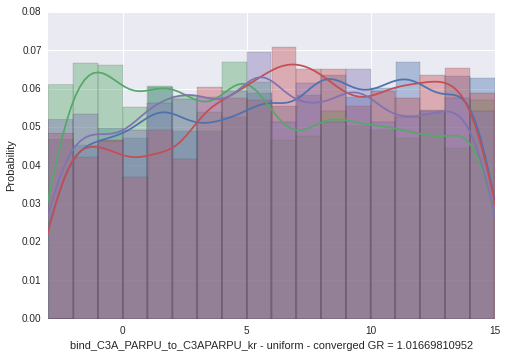

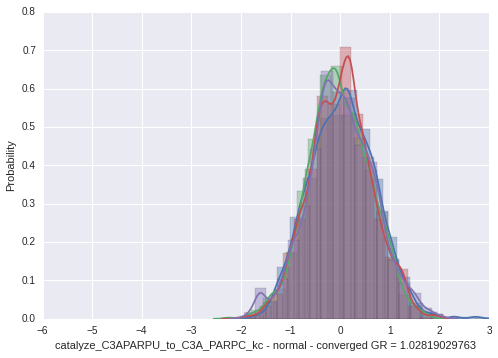

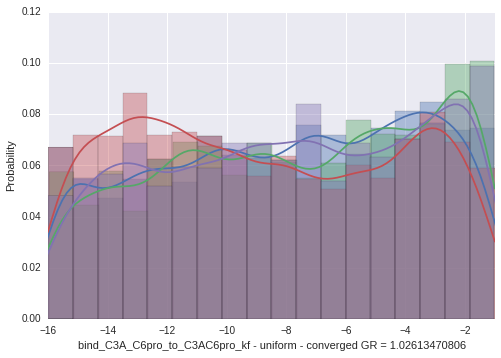

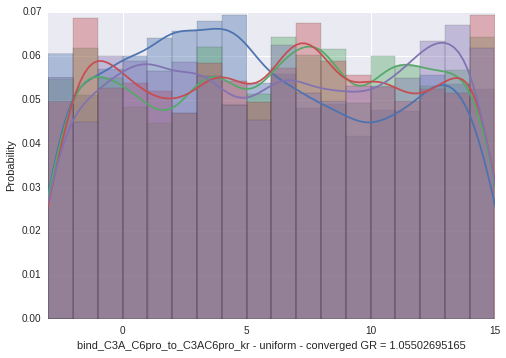

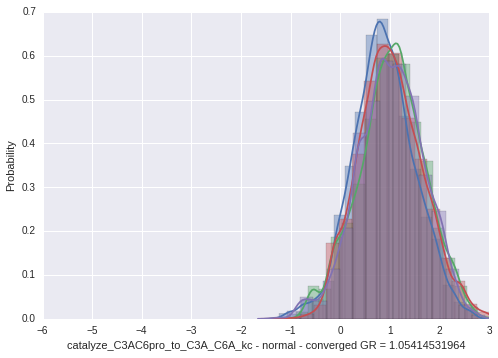

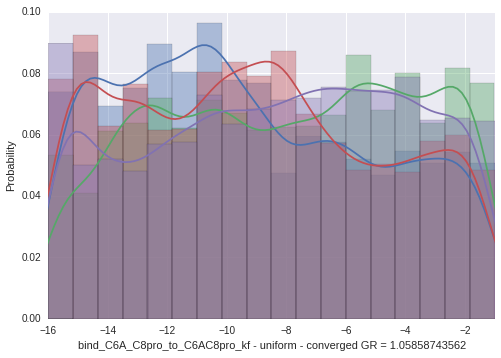

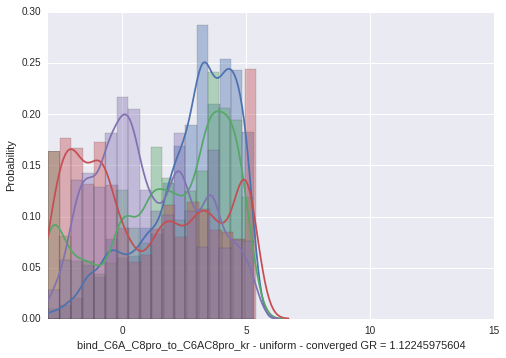

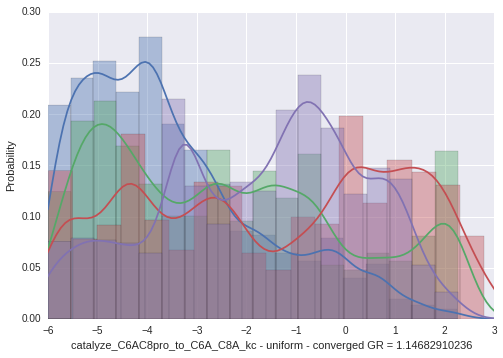

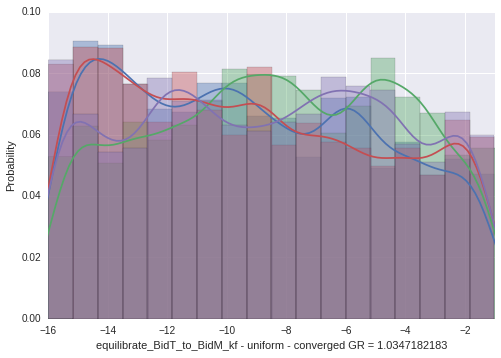

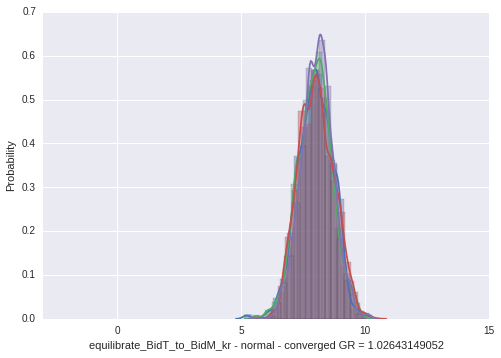

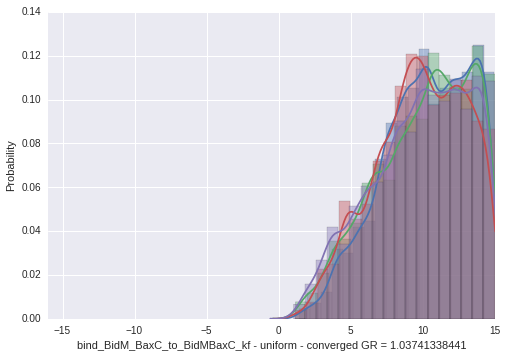

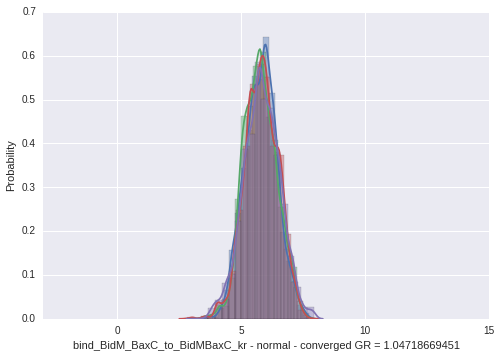

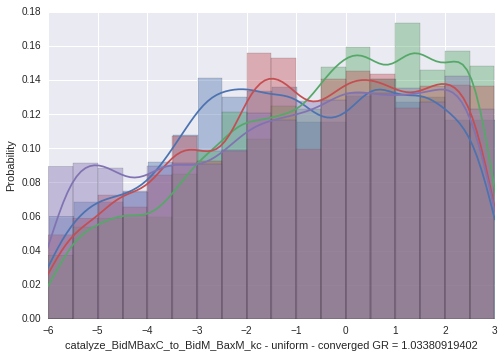

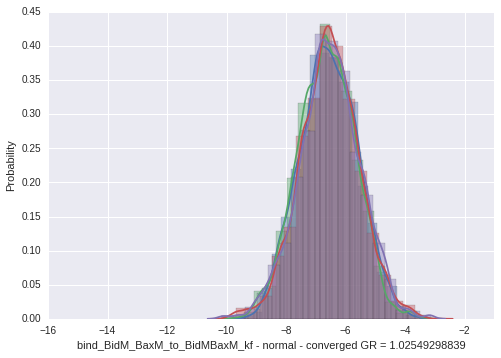

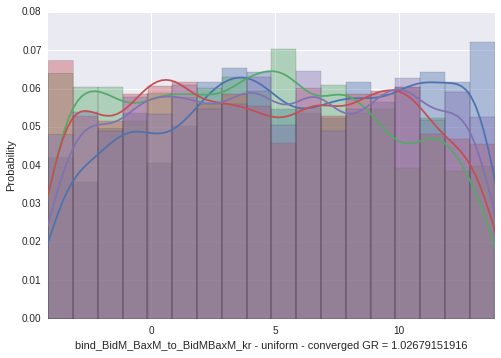

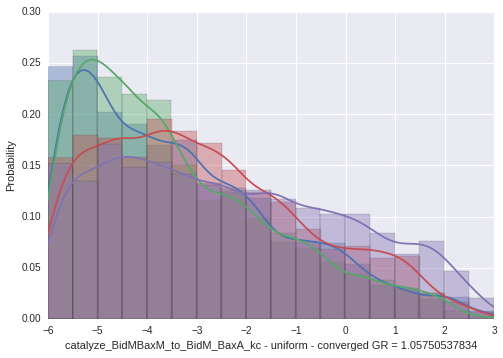

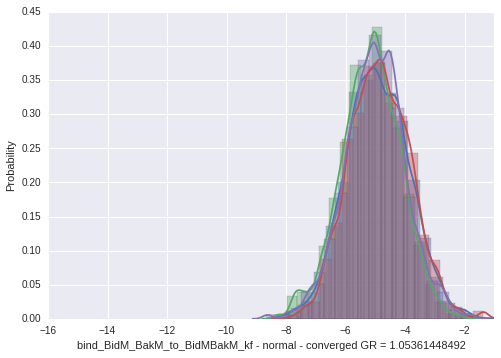

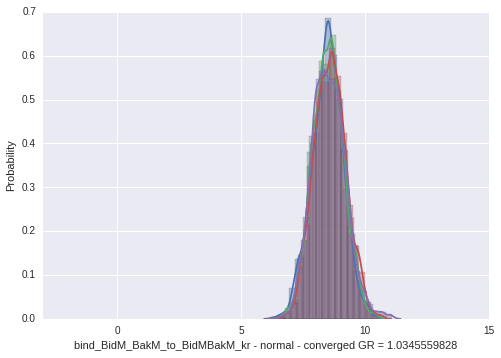

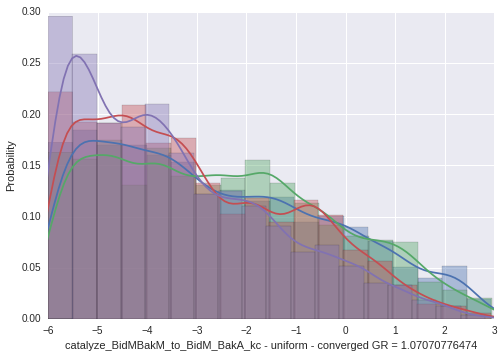

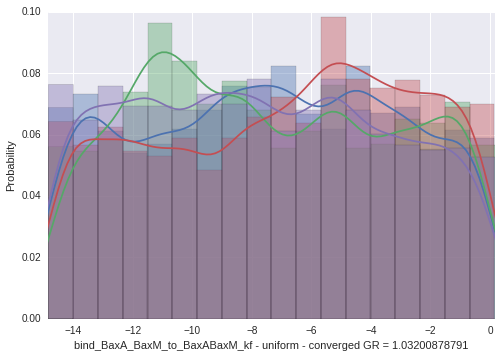

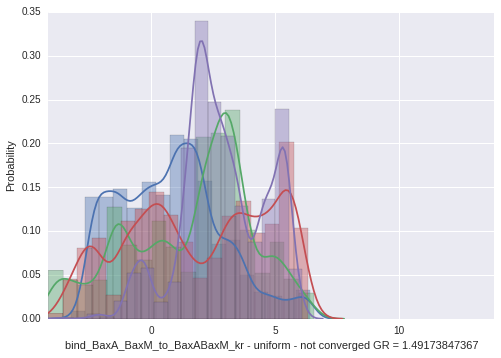

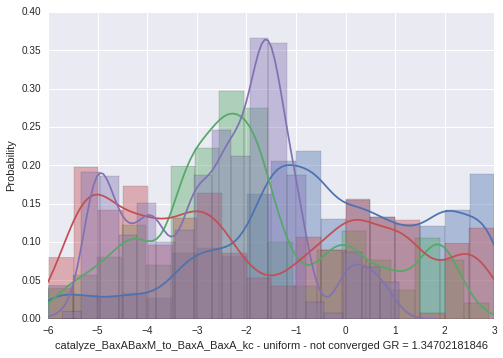

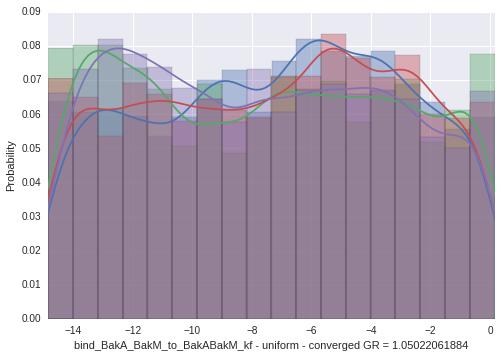

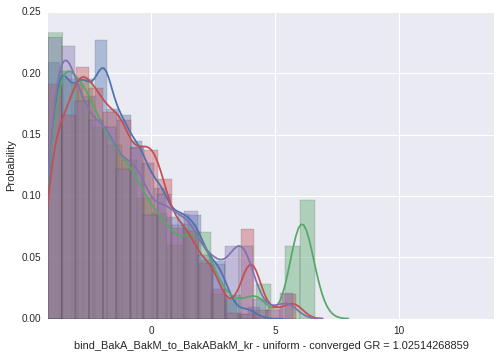

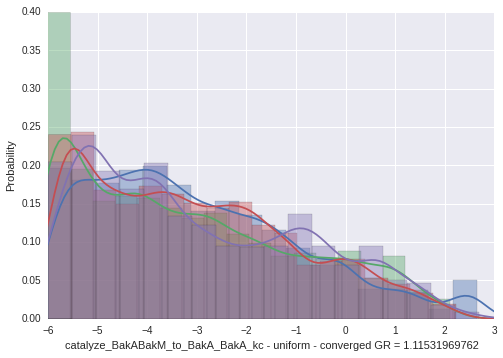

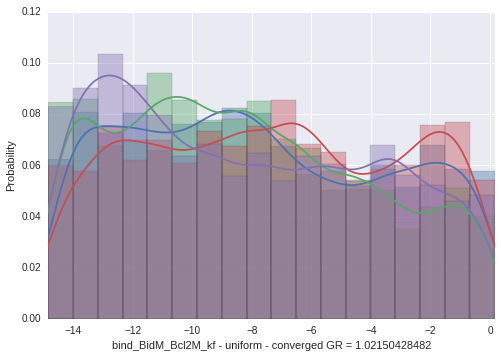

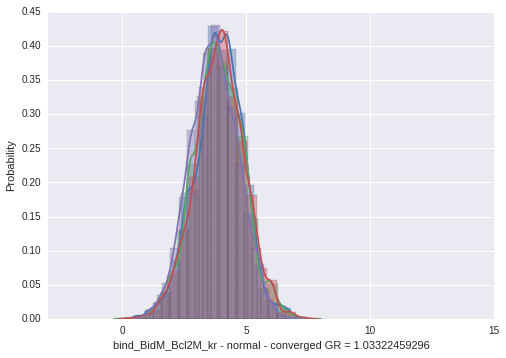

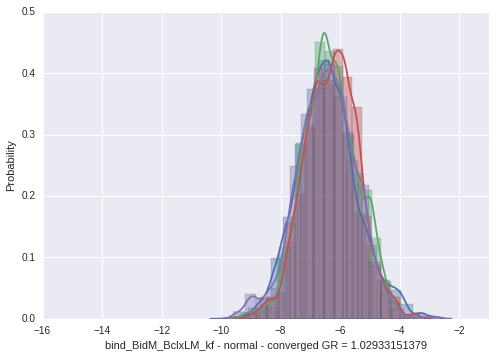

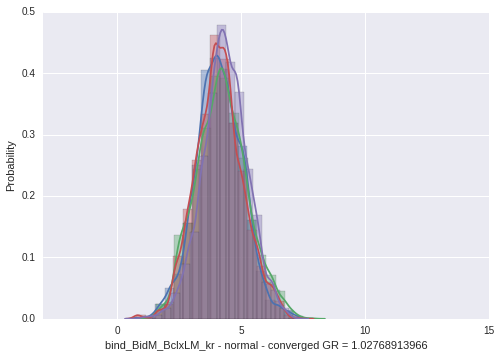

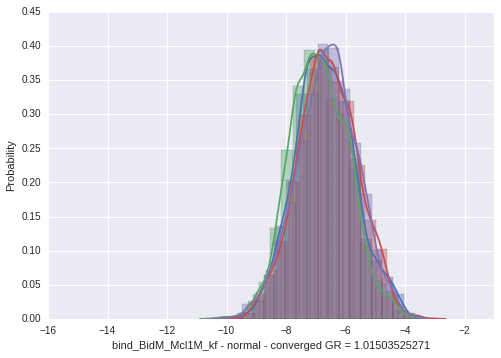

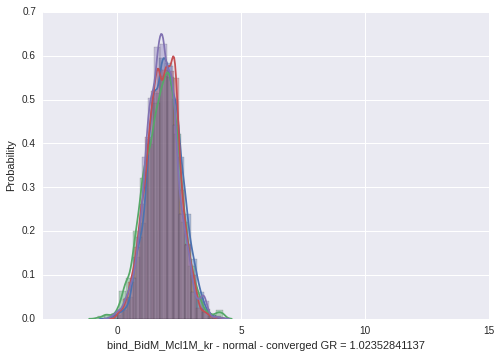

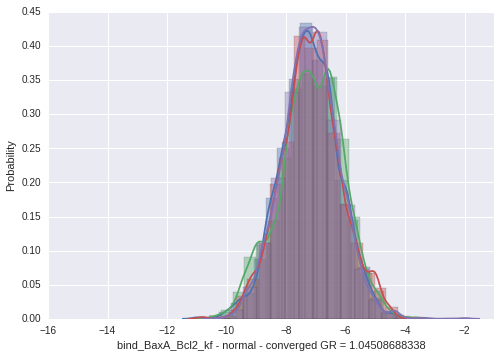

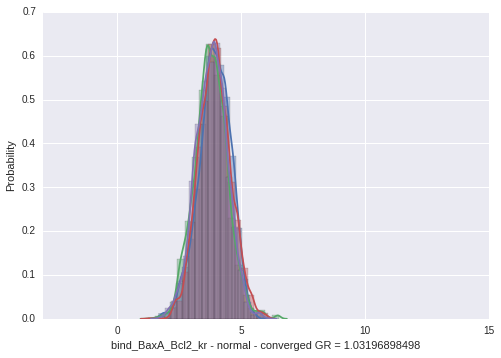

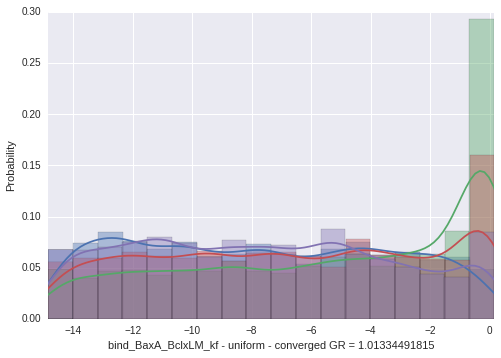

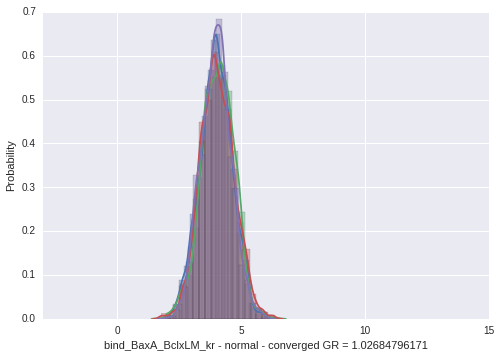

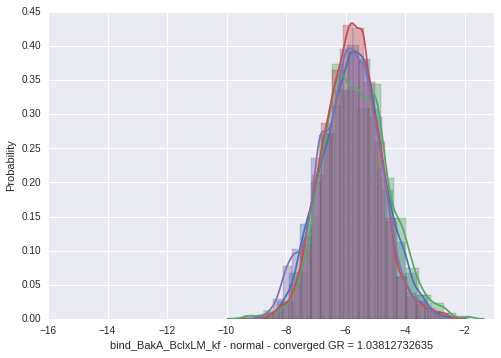

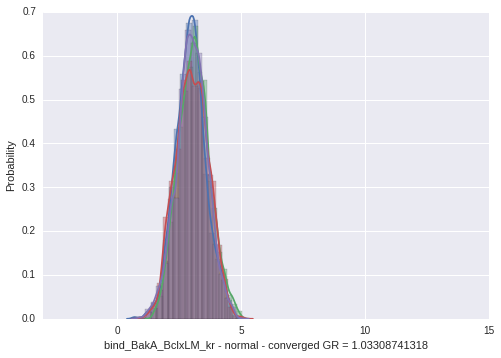

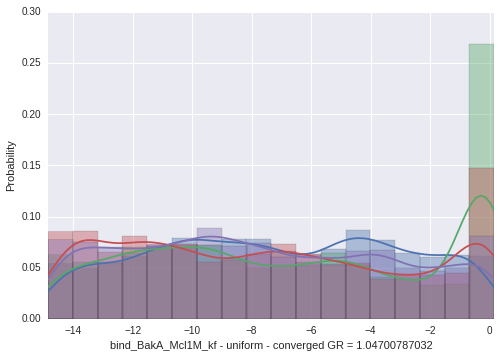

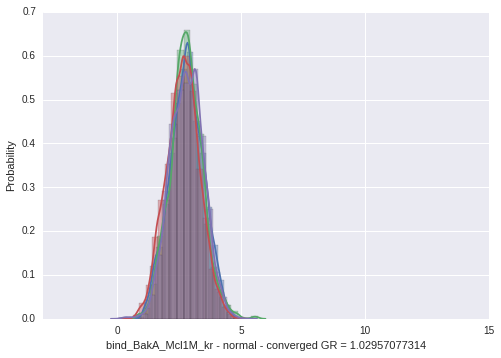

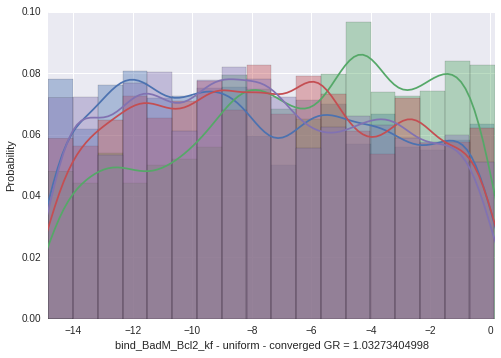

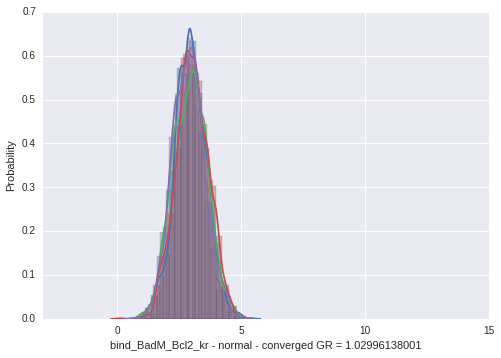

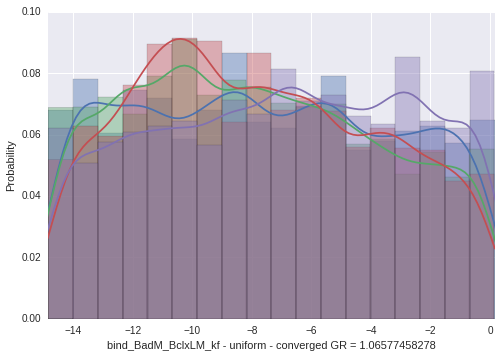

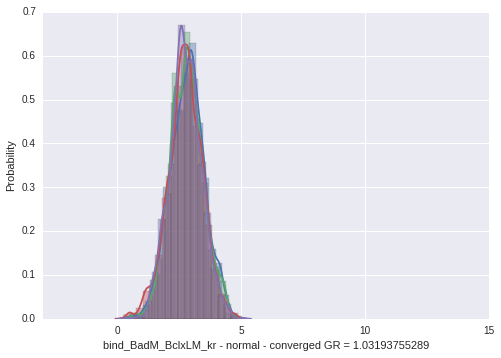

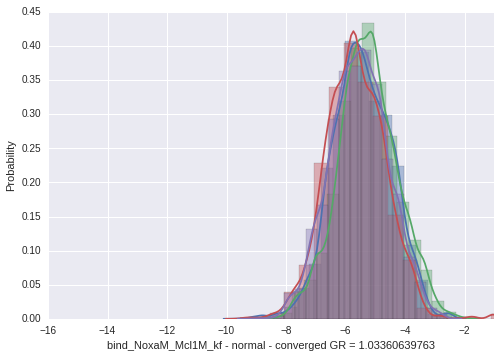

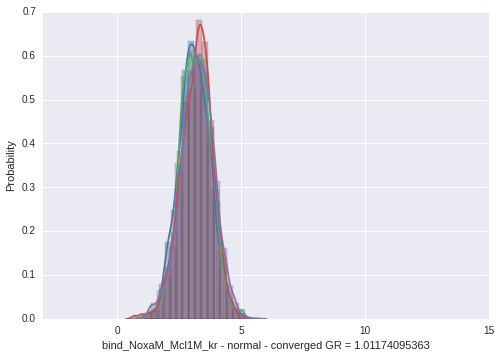

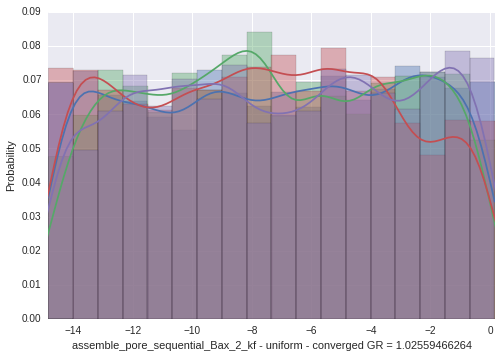

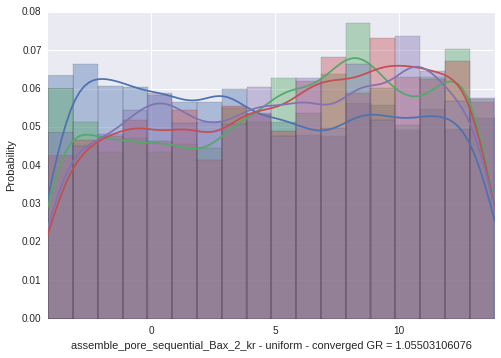

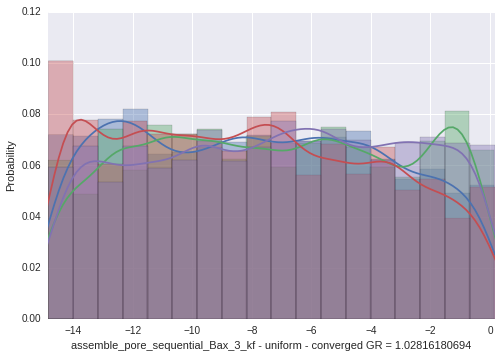

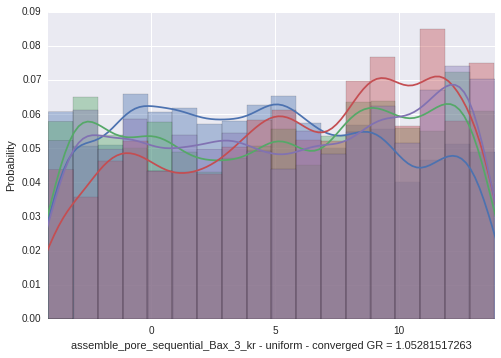

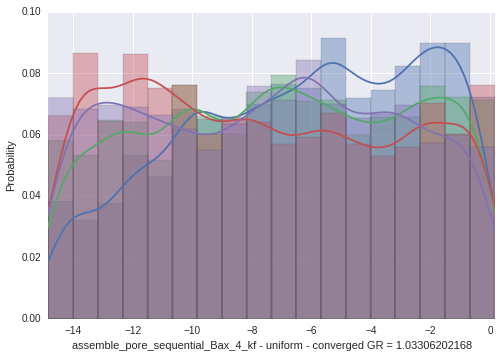

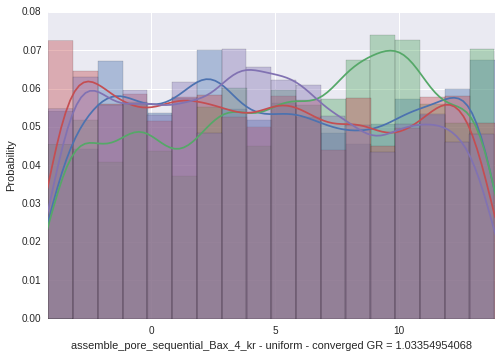

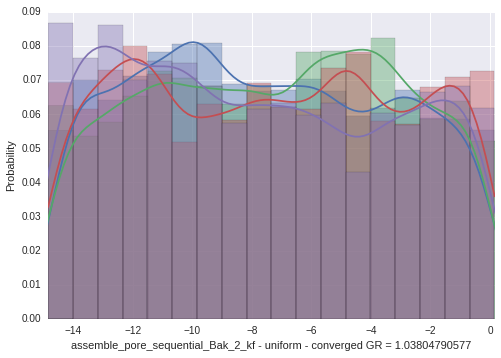

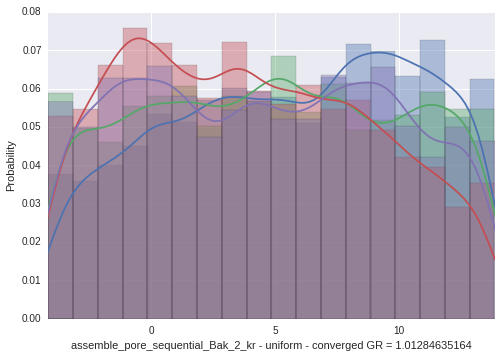

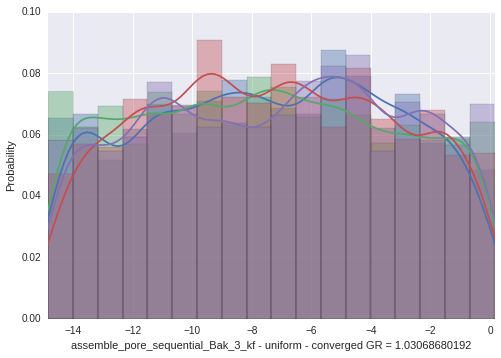

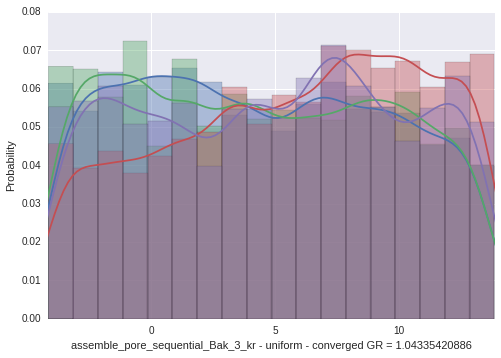

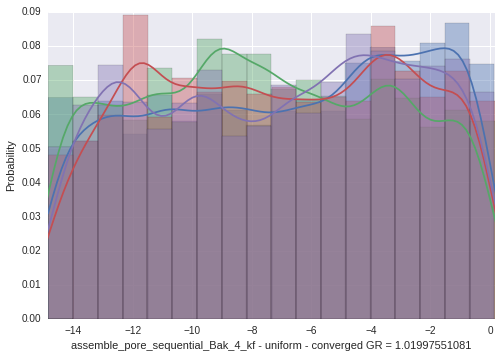

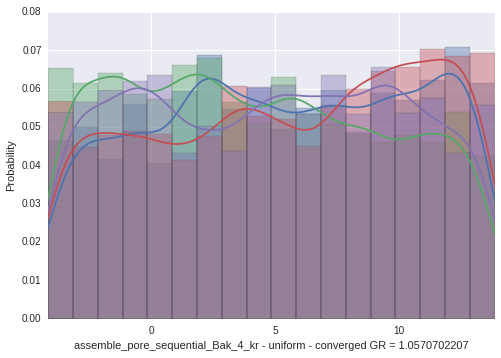

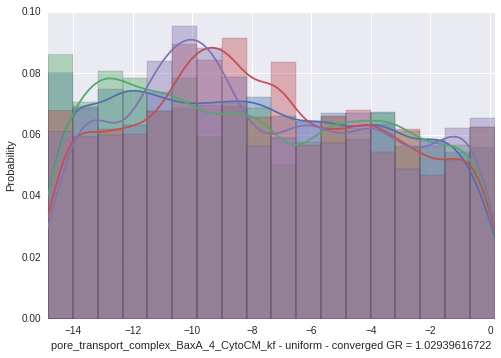

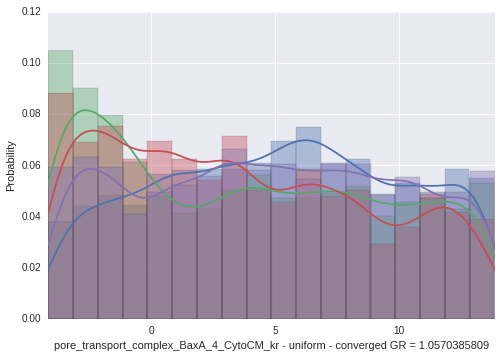

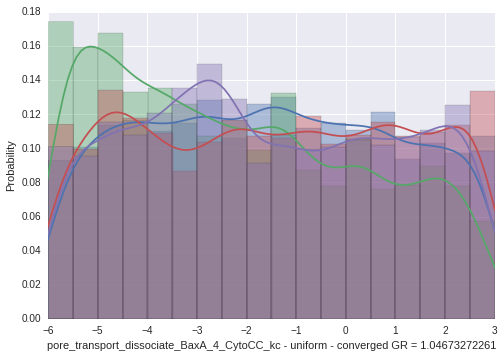

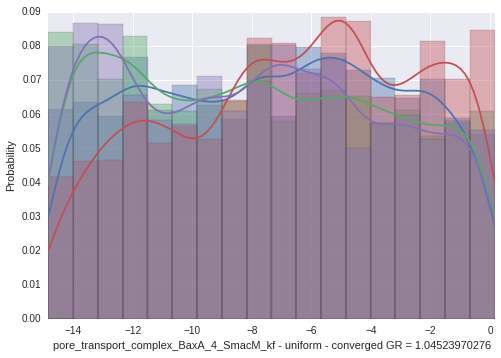

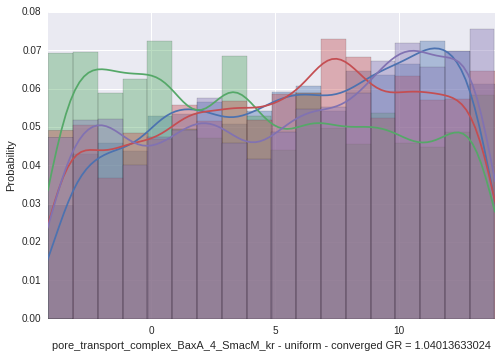

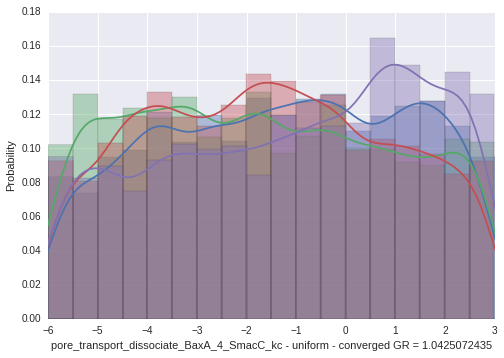

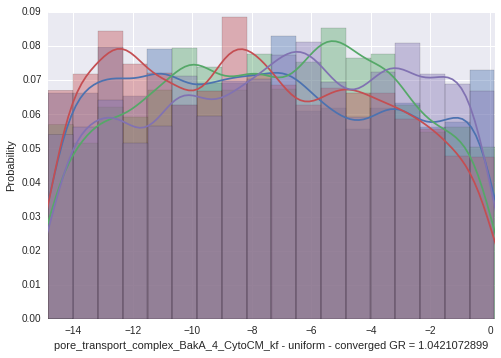

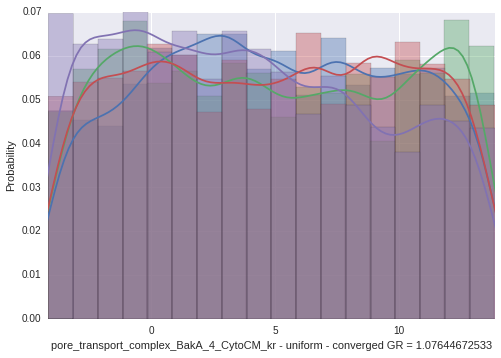

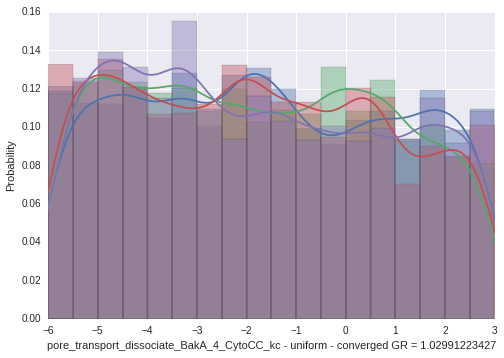

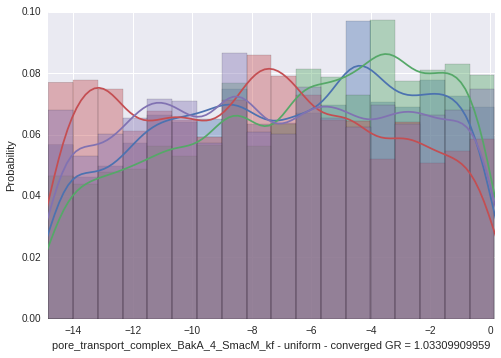

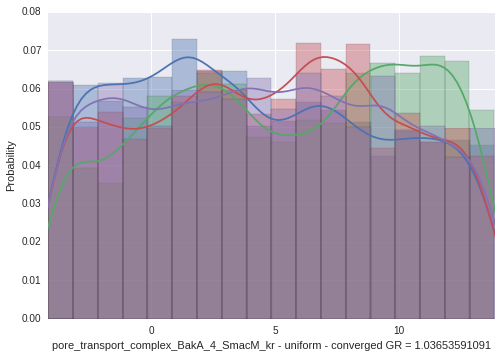

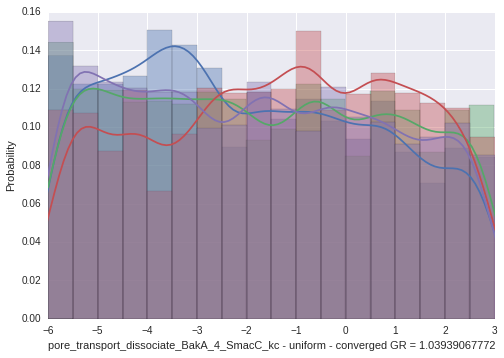

In [28]:
for dim, param_name in enumerate([param.name for param in model.parameters_rules()]):
    fig = plt.figure()
    sns.plotting_context('notebook')
    ax = sns.distplot(trace_arr_a[:,dim], hist=True, bins=18)
    sns.distplot(trace_arr_b[:,dim], hist=True, bins=18)
    sns.distplot(trace_arr_c[:,dim], hist=True, bins=18)
    sns.distplot(trace_arr_d[:,dim], hist=True, bins=18)
    if gelman_rubin_dicts['a'][param_name] < 1.2:
        sns.axlabel(param_name+' - '+earm_rates[param_name]['type']+' - converged GR = '+str(gelman_rubin_dicts['a'][param_name]), 'Probability')
    else:
        sns.axlabel(param_name+' - '+earm_rates[param_name]['type']+' - not converged GR = '+str(gelman_rubin_dicts['a'][param_name]), 'Probability')
    if earm_rates[param_name]['type'] == 'uniform':
        ax.set_xlim([earm_rates[param_name]['lower'], earm_rates[param_name]['upper']])
    elif 'kf' in param_name:
        ax.set_xlim([-16, -1])
    elif 'kr' in param_name:
        ax.set_xlim([-3, 15])
    elif 'kc' in param_name:
        ax.set_xlim([-6, 3])

In [8]:
import pandas as pd

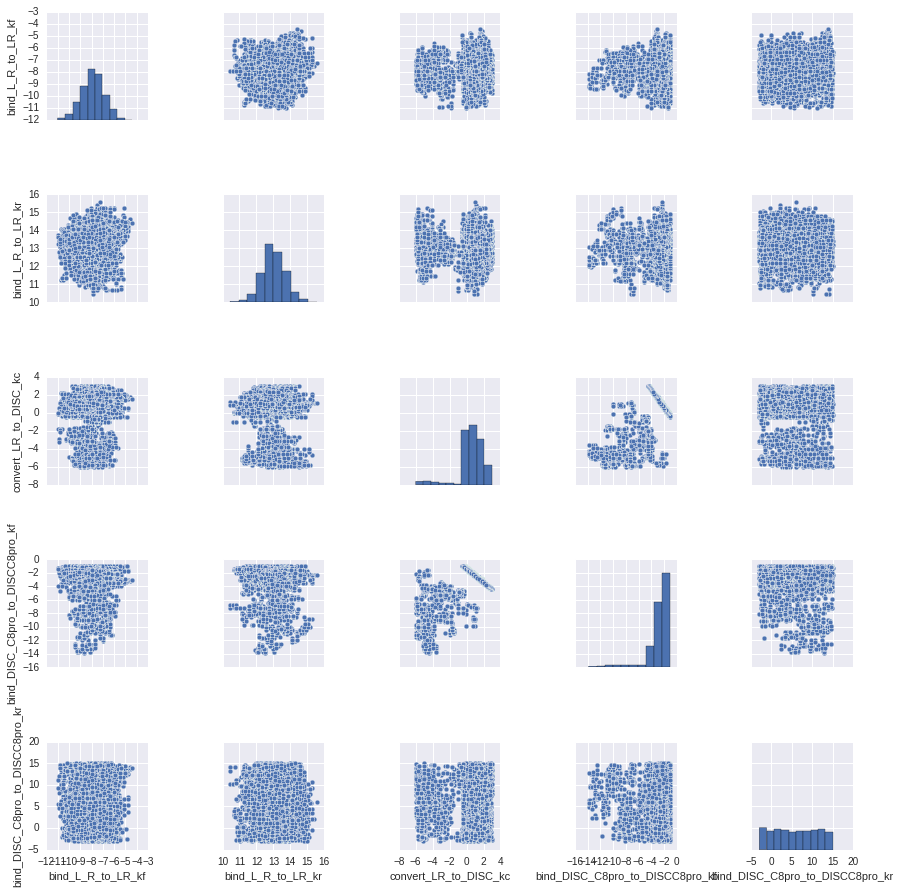

In [12]:
df_a = pd.DataFrame(trace_arr_a, columns=param_trace_dict_a['param_list'])
sns.pairplot(df_a, vars=param_trace_dict_a['param_list'][0:5])

In [37]:
os.chdir('/home/shockle/emcee')
from emcee import autocorr
autocorr.integrated_time(trace_arr_a, window=50)

array([ 169.75660161,  171.81365967,  195.00427618,  195.18299733,
        176.77221286,  180.51294508,  181.07639975,  175.59119728,
        177.79543375,  177.15077603,  177.33184308,  182.17476904,
        179.37285039,  192.79497608,  192.11861253,  174.68522599,
        176.97797567,  175.18003712,  175.16438432,  176.17104247,
        174.092557  ,  177.16106308,  178.17552699,  177.76628758,
        173.10544873,  169.79480546,  167.88014033,  171.19715968,
        173.20763587,  175.29633301,  177.08847824,  168.37643061,
        173.18429027,  168.70901454,  176.58026914,  177.37171965,
        177.79851689,  173.39851452,  178.13640036,  177.50508953,
        176.95194561,  177.95614322,  192.37377158,  192.41756217,
        173.44825735,  166.53701318,  171.18377845,  175.56582945,
        177.19938879,  174.82934725,  176.88676663,  177.41897879,
        171.95278266,  167.2409243 ,  181.0175908 ,  176.32939059,
        195.84613727,  195.29163204,  175.22635536,  175.44043

In [10]:
from likelihood_fxn import likelihood

In [17]:
df = pd.DataFrame(trace_arr_a, columns=param_trace_dict_a['param_list'])
uniques = pd.unique(df.values)

array([ -8.04675968,  12.01870999,   0.49758838,  -2.01622531,
         7.986512  ,  -4.74309024, -15.64536628,   7.92822119,
         0.98119573,  -9.6739192 ,   5.5481718 , -13.70569948,
        13.29067716, -11.92458191,   8.36974996, -12.16985657,
         4.82485102,  -1.19757559,   5.97619741,  -0.16520577,
        -9.5684717 ,   4.52755777, -12.61614029,   2.60820504,
        -1.02263279,  -8.36904886,   4.28630308,  -4.97484877,
         6.28338921,  -9.44546215,  13.88334425,  -0.45048688,
        -4.19723618,   2.47317634,  -5.69352893,  -3.67221752,
         8.05117452,  -0.16493244,  -6.40045735,   3.6576545 ,
         0.91806213, -13.76683573,   2.75063033,  -3.4686828 ,
        -6.92059031,   8.29512978,  13.28098164,   6.83181049,
        -0.37227714,  -7.0610374 ,   4.21984061,  -3.14701307,
        -4.46357109,   7.17032582,  -2.76141768,  -9.59384511,
        -0.02410347,   0.38198937, -10.3769731 ,   0.91097913,
        -3.95124129,  -8.26804251,   4.83983259,  -6.48

In [18]:
momp_sims = {}
other_sims = {}
likes = {}
i = 0
for arr in [trace_arr_a, trace_arr_b, trace_arr_c, trace_arr_d]:
    df = pd.DataFrame(arr, columns=param_trace_dict_a['param_list'])
    uniques = pd.unique(df.values)
    n = 0
    for param_vec in uniques:
        like, sims, momp_sim = likelihood(np.array(param_vec))
        momp_sims[str(i)+'_'+str(n)] = momp_sim
        other_sims[str(i)+'_'+str(n)] = other_sims
        likes[str(i)+'_'+str(n)] = like
        n += 1
    i += 1
        

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/_ode.py:741: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  'Unexpected istate=%s' % istate))
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/_ode.py:741: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  'Unexpected istate=%s' % istate))


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/_ode.py:741: UserWarning: vode: Repeated error test failures. (Check all input.)
  'Unexpected istate=%s' % istate))


likelihood:  -4746.29439322


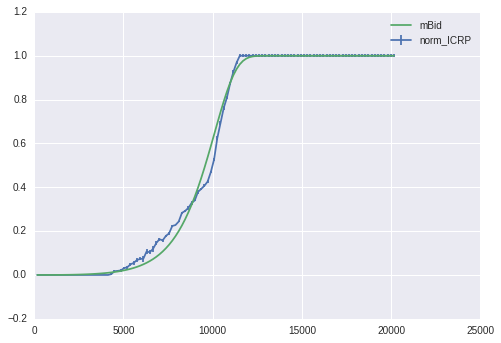

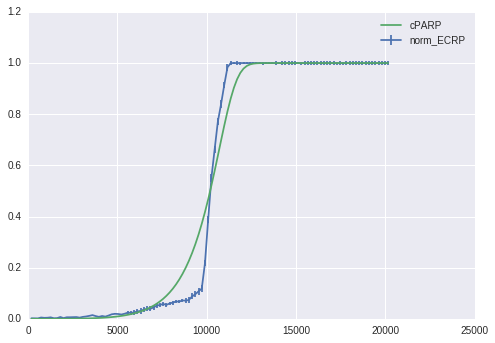

In [13]:
for obs_name, data_name, var_name, obs_total in \
            zip(obs_names, data_names, var_names, obs_totals):
    # Normalize it to 0-1
    ysim_norm = sims[obs_name]
    # Get experimental measurement and variance
    ydata = exp_data[data_name]
    yvar = exp_data[var_name]
    fig = plt.figure()
    plt.errorbar(tspan[::tmul], ydata, yerr=yvar, label=data_name)
    plt.plot(tspan[::tmul], ysim_norm, label=obs_name)
    plt.legend()

In [14]:
from scipy.stats import norm
momp_td_rv = norm(loc=momp_data[0], scale=momp_var[0])
momp_ts_rv = norm(loc=momp_data[1], scale=momp_var[1])
momp_yf_rv = norm(loc=momp_data[2], scale=momp_var[2])

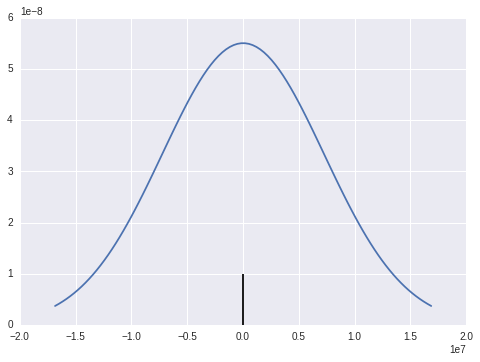

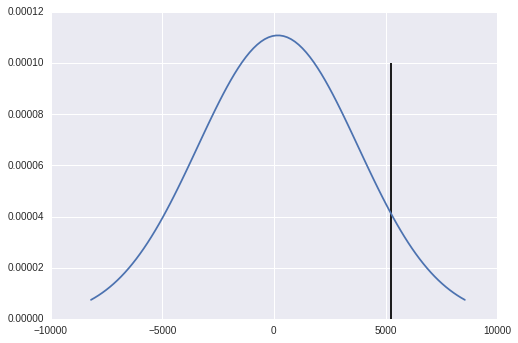

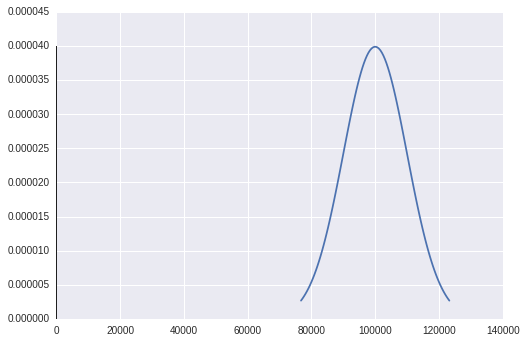

In [24]:
fig = plt.figure()
x = np.linspace(momp_td_rv.ppf(0.01), momp_td_rv.ppf(0.99), 100)
plt.plot(x, momp_td_rv.pdf(x))
plt.vlines(momp_sim[0], 0, 1e-8)
fig = plt.figure()
x = np.linspace(momp_ts_rv.ppf(0.01), momp_ts_rv.ppf(0.99), 100)
plt.plot(x, momp_ts_rv.pdf(x))
plt.vlines(momp_sim[1], 0, .0001)
fig = plt.figure()
x = np.linspace(momp_yf_rv.ppf(.01), momp_yf_rv.ppf(0.99), 100)
plt.plot(x, momp_yf_rv.pdf(x))
plt.vlines(momp_sim[2], 0, 4e-5)

In [26]:
norm.logpdf(momp_sim, momp_data, momp_var)
norm.logpdf(sims['mBid'], exp_data['norm_ICRP'], exp_data['nrm_var_ICRP'])

array([  6.49964237e+00,   6.49964186e+00,   6.49958740e+00,
         6.49892198e+00,   6.49541553e+00,   6.48338966e+00,
         6.45143871e+00,   6.37961531e+00,   6.23595075e+00,
         5.97209710e+00,   5.51779920e+00,   4.77379474e+00,
         3.60264244e+00,   1.81680883e+00,  -8.36843486e-01,
        -4.69727353e+00,  -1.02156240e+01,  -1.79895753e+01,
        -2.88080896e+01,  -4.37096624e+01,  -6.40580291e+01,
        -9.16405094e+01,  -1.28795557e+02,   2.71982191e+00,
         4.15694244e+00,   4.25552190e+00,   4.20336974e+00,
         2.42413574e+00,   2.62367775e+00,   4.74281939e-01,
        -2.53029970e-02,  -4.66009846e+00,  -6.44557914e+00,
         1.68517650e+00,  -8.52631194e+00,  -5.44058687e+00,
        -3.92794837e+00,  -2.45401557e+01,  -5.44691819e+01,
        -3.67606989e+01,  -5.02810516e+01,  -4.52587843e+01,
        -5.24864479e+01,  -3.16046200e+02,  -1.16009578e+02,
        -1.16516867e+02,  -4.77270824e+01,   1.42795271e+00,
         3.32543854e+00,